In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

In [3]:
def prep_data(thresh):
    df = pd.read_csv(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", sep="\t", index_col=0)
    unique_cnts = df.nunique(axis=0)
    const_feats = unique_cnts[unique_cnts == 1]
    df.drop(const_feats.index.tolist(), axis=1, inplace=True)
    return df

In [4]:
score_df = pd.read_csv(f"../data/tatoeba_train_opus_scores.tsv", sep="\t", index_col=0)

y = score_df.bleu

del score_df

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

In [7]:
RANDOM_SEED = 0

In [8]:
def get_metrics(alphas, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in alphas:
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2s.append(r2_score(y_test, y_pred))
        mses.append(mean_squared_error(y_test, y_pred))

    return np.array(r2s), np.array(mses)

In [9]:
def plot_metrics(thresh, alphas, r2s, mses, additional_info="full"):
    plt.figure(figsize=(8, 6))

    sns.lineplot(x=alphas, y=r2s)

    ax = plt.gca()
    ax.set_xscale("log")
    ax.set(
        xlabel="Regularization coefficient", 
        ylabel="$ R^2 $",
        title=f"Metrics for linear regression\nTopological features, threshold {thresh}, {additional_info}"
    )

    ax.grid()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

    plt.show()

In [32]:
from functools import partial
from multiprocess.pool import Pool

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [37]:
def suppressed_vif(X, idx):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return variance_inflation_factor(X, idx)

def calculate_vif_(X, thresh=5.0, verbose=False):
    pool = Pool(processes=8)
    variables = np.array(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif_func = partial(suppressed_vif, X.iloc[:, variables].values)
        args = list(range(X.iloc[:, variables].shape[1]))
        vif = pool.map(vif_func, args)

        vif = np.array(vif)
        if vif.max() > thresh:
            if verbose:
                print("dropping", X.columns[variables[vif == vif.max()]])
            variables = variables[vif < vif.max()]
            dropped = True

    pool.close()
    if verbose:
        print("Remaining variables:")
        print(X.columns[variables])
    return variables

In [38]:
import os
import sys

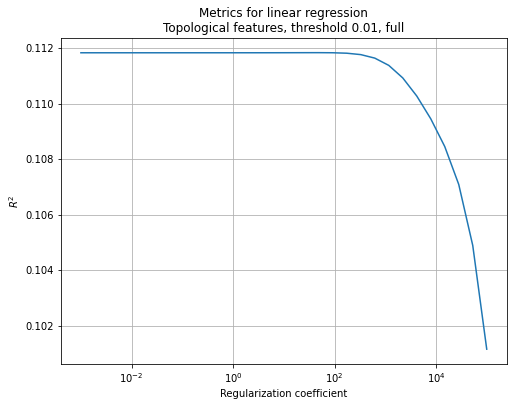

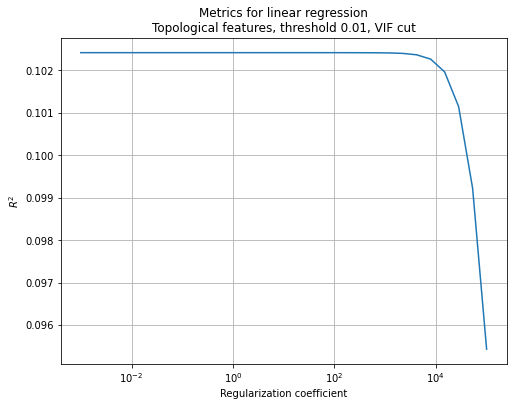

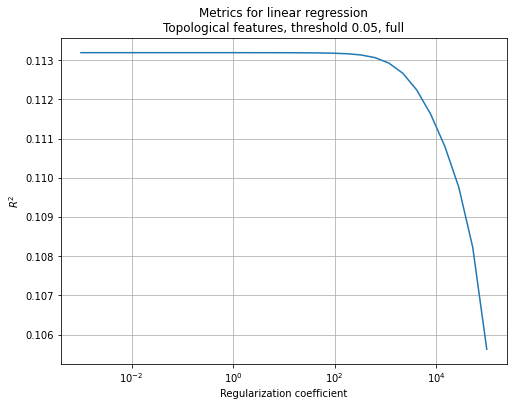

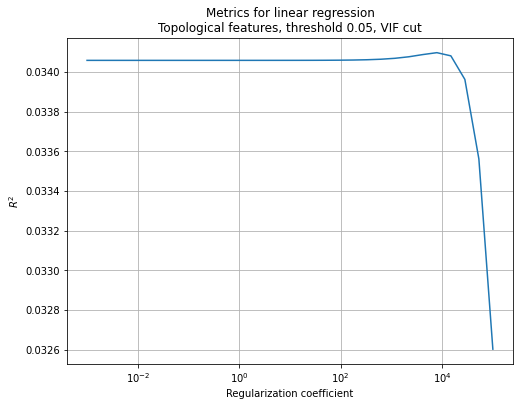

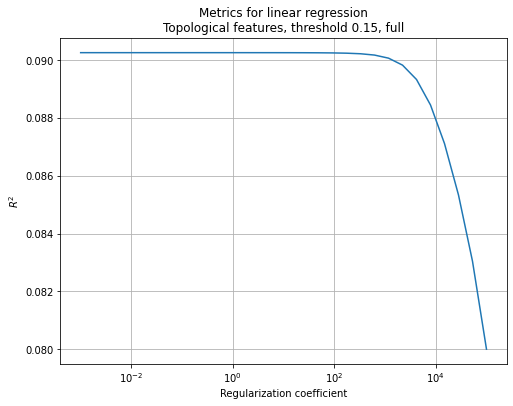

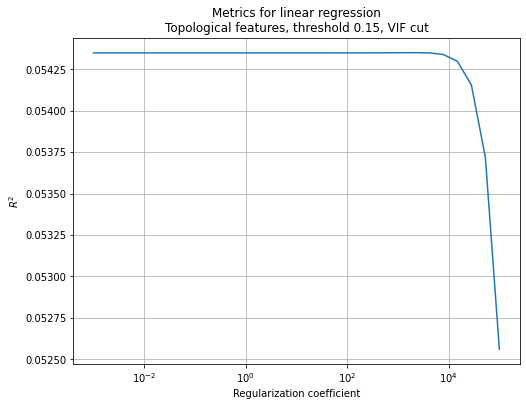

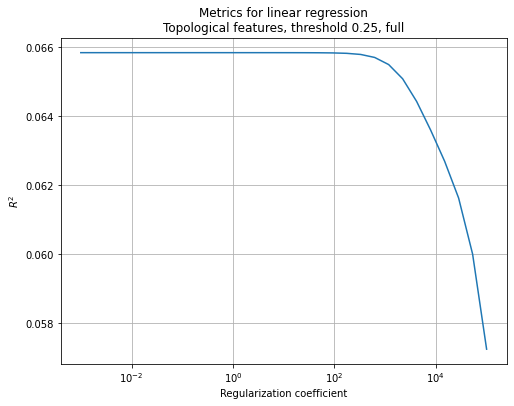

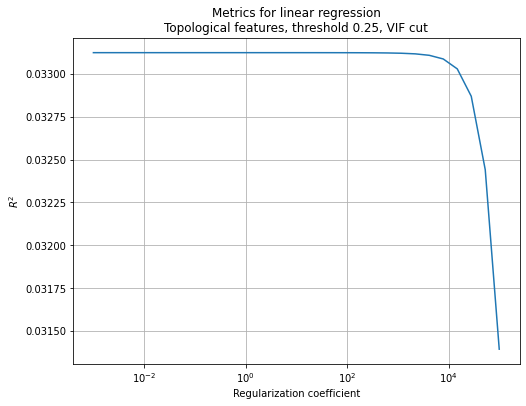

In [39]:
threshs = [0.01, 0.05, 0.15, 0.25]

alphas = np.logspace(-3, 5, num=30)

full_r2s = []
cut_r2s = []

for thresh in threshs:
    X = prep_data(thresh)
    X = X.loc[y.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.4)
    del X

    used_vars = calculate_vif_(X_train.sample(500))

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, (X_train, X_test), (y_train, y_test))
    plot_metrics(thresh, alphas, r2s, mses)
    full_r2s.append(r2s.max())

    r2s, mses = get_metrics(alphas, (X_train[:, used_vars], X_test[:, used_vars]), (y_train, y_test))
    plot_metrics(thresh, alphas, r2s, mses, "VIF cut")
    cut_r2s.append(r2s.max())

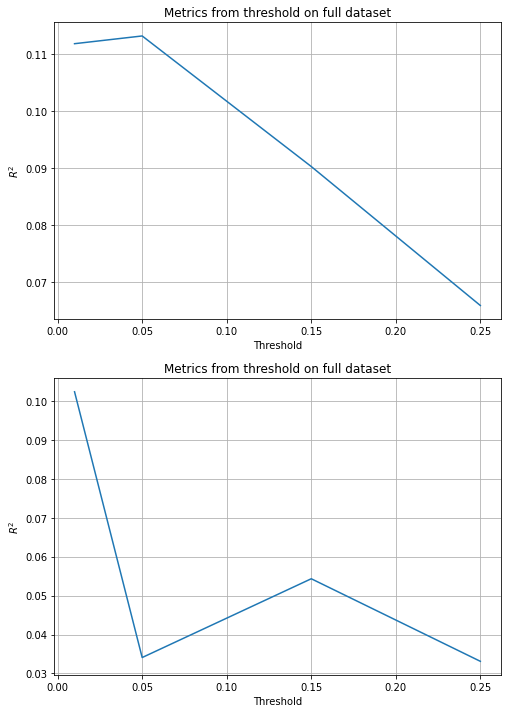

In [40]:
plt.figure(figsize=(8, 12))

plt.subplot(211)

sns.lineplot(x=threshs, y=full_r2s)

ax = plt.gca()
ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")

ax.grid()

plt.subplot(212)

sns.lineplot(x=threshs, y=cut_r2s)

ax = plt.gca()
ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")

ax.grid()

plt.show()

In [50]:
from getpass import getpass
import mlflow

os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = getpass("Enter your DAGsHub access token: ")

mlflow.set_tracking_uri("https://dagshub.com/no-brainer/tda-mt.mlflow")

In [52]:
for thresh, r2_score in zip(threshs, cut_r2s):
    with mlflow.start_run():
        mlflow.log_metric("r2", r2_score)
        mlflow.log_param("experiment_type", "bleu_prediction")
        mlflow.log_param("features_path", f"../data/tatoeba_tf_train_thresh{thresh}.tsv")
        mlflow.log_param("target_path", "../data/tatoeba_train_opus_scores.tsv")
        mlflow.log_param("train_test_split", dict(random_seed=RANDOM_SEED, test_size=0.4))
        mlflow.log_param("data", "cut with VIF")

## Coefficients

In [77]:
X = prep_data(0.05)
X = X.loc[y.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED, test_size=0.4)

columns = X.columns

del X

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
model = Ridge().fit(X_train, y_train)

In [82]:
coef_df = pd.DataFrame(data=model.coef_, index=columns)
coef_df = coef_df.reset_index()
coef_df.columns = ["feature", "coef"]

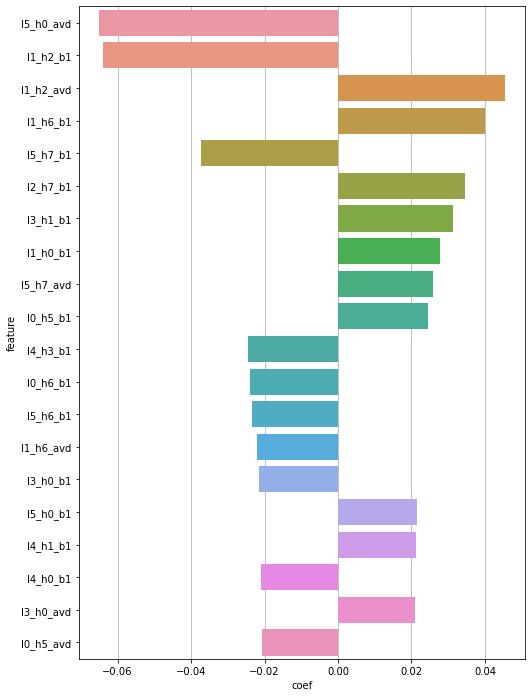

In [94]:
plt.figure(figsize=(8, 12))

sns.barplot(
    data=coef_df.sort_values(by="coef", key=abs, ascending=False).head(20),
    x="coef",
    y="feature",
    zorder=10,
)

plt.grid(axis="x")

plt.show()